# DIASources detection and characterization

## PART 1:  DIASource detection and measurement in ONE CCD.

Obligatory imports

In [7]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import re

import lsst.afw.display.ds9 as ds9

import matplotlib.pyplot as plt

from lsst.ip.diffim import ImagePsfMatchTask, DipoleMeasurementTask
from lsst.meas.base import SingleFrameMeasurementConfig
import lsst.afw.table as afwTable

import lsst.daf.base as dafBase
import DiaSourceTools as DSTools

import lsst.meas.algorithms.detection as sDet
import lsst.afw.image as afwImage

from lsst.meas.algorithms.detection import SourceDetectionTask




import lsst.afw.geom as afwGeom
import random
%matplotlib inline

In [128]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0,0,0),(0.5,0,0), (1,0,0), (0,0,1), (1,0,1)]
cm = LinearSegmentedColormap.from_list('dipoles', colors, N=5)

colors = [(1,1,1),(0.5,0,0), (1,0,0), (0,0,1), (1,0,1)]
cm2 = LinearSegmentedColormap.from_list('dipoles', colors, N=5)

def SubtractBackground(exp):
  
    bgConf = sDet.BackgroundConfig()
    background,Exp0 = sDet.estimateBackground(exp,bgConf,True)

    return background, Exp0

def merge_sources(results):
    fpSet = results.fpSets.positive
    fpSet.merge(results.fpSets.negative, 1, 1, False)
    diaSources = afwTable.SourceCatalog(table)
    fpSet.makeSources(diaSources)
    return diaSources

def remove_nan_sources(diaSources):
    c_diaSources = diaSources.copy()
    c_diaSources.clear()
    for diaSrc in diaSources:
        val = diaSrc.get("coord_ra").asArcseconds()
        if np.isnan(val) == False:
            c_diaSources.append(diaSrc)
        
    return c_diaSources

def get_source_stamp(src, visit, ccds, offset=0):
    
    for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
            bbox = diffExp.getBBox()
            wcs = diffExp.getWcs()
            
            c = afwGeom.Point2I(wcs.skyToPixel(src.getRa(), src.getDec()))
            
            if bbox.contains(c):
                psf = diffExp.getPsf()
                shape = psf.computeShape()
                sigma = shape.getDeterminantRadius()
                #print sigma
                
                return DSTools.get_stamp(src, diffExp, offset=offset), c
            
    return None, None  

def get_dipole_lobes_metrics(stamp):
    w,h = stamp.getWidth(), stamp.getHeight()
    pos_fp = stamp_clone.getMaskedImage().getMask().getPlaneBitMask("DETECTED")
    neg_fp = stamp_clone.getMaskedImage().getMask().getPlaneBitMask("DETECTED_NEGATIVE")

    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
    
    values = (mask_arr & pos_fp == pos_fp)
    values2 = values & (img_arr > 0)
    pos_pixels = len(img_arr[values])
    pos_flux=  np.sum(abs(img_arr[values2]))

    values = (mask_arr & neg_fp == neg_fp)
    values2 = values & (img_arr < 0)
    neg_flux= np.sum(abs(img_arr[values2]))
    neg_pixels = len(img_arr[values])

    values = mask_arr & (neg_fp|pos_fp) == (neg_fp|pos_fp)
    inter_flux = np.sum(abs(img_arr[values]))
    inter_pixels = len(img_arr[values])

    values = mask_arr & (neg_fp|pos_fp) != 0
    total_flux = np.sum(abs(img_arr[values]))
    mask_pixels = len(img_arr[values])
    
    fluxes = [inter_flux/total_flux, pos_flux/total_flux, neg_flux/total_flux]
    geom = [float(inter_pixels)/mask_pixels, float(pos_pixels)/mask_pixels, float(neg_pixels)/mask_pixels]
    

    return fluxes, geom
    

def show_stamps(stamp, title='Stamp'):

    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()
    w,h = stamp.getWidth(), stamp.getHeight()
    plt.figure(figsize=(16,5))
    
    plt.suptitle(title)
    
    plt.subplot(1,3,1)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')


    plt.subplot(1,3,2)
    plt.imshow(mask_arr, origin='lower',  vmin=0, vmax=mask_arr.max(), cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')


    plt.subplot(1,3,3)
    layer_mask = mask_arr.copy()
    layer_mask = np.ma.masked_where(layer_mask==0, layer_mask)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')
    plt.imshow(layer_mask, origin='lower', alpha=0.3, vmin=0, vmax=mask_arr.max(), cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')
    
def visualize_dipoles_and_planes(stamp, source):
    
    plCak = source.getFootprint().getPeaks()
    
    w,h = stamp.getWidth(), stamp.getHeight()
    img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()

    plt.figure(figsize=(16,5))

    plt.subplot(1,2,1)
    plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray', extent=(0,w-1, 0, h-1), interpolation='none')

    for pk in pkCat:
        if pk.getPeakValue() < 0:
            plt.plot(pk.getIx()-stamp.getX0(), pk.getIy()-stamp.getY0(), 'bo')
        else:
            plt.plot(pk.getIx()-stamp.getX0(), pk.getIy()-stamp.getY0(), 'ro')

    plt.subplot(1,2,2)
    im = plt.imshow(mask_arr, origin='lower', vmin=0, vmax=100, cmap=cm, extent=(0,w-1, 0, h-1), interpolation='none')
    
def photo_dipole(photo_prop):
    return photo_prop[1] < 0.66 and photo_prop[2] < 0.66

def geom_dipole(geom_prop):
    return geom_prop[0]<0.33


This part is <b>very important</b>. Detection and measurement tasks are going to use the same schema, which is gonna be modified to contain all measurement fields upon the task instantiation. Not doing the task instantiation before running the measurement is going to cause errors. You've been warned

In [8]:
algMetadata = dafBase.PropertyList()
schema = afwTable.SourceTable.makeMinimalSchema()

dipoleMeasurement = DipoleMeasurementTask

config = dipoleMeasurement.ConfigClass()
dipoleMeasurement = dipoleMeasurement(schema, algMetadata=algMetadata)

In-disk path to dataset

In [9]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
diffExp1 = butler.get("deepDiff_differenceExp", {'visit': 849687 , 'filter':'r' , 'ccd':14})
diaSrcs1 = butler.get("deepDiff_diaSrc", {'visit': 849687 , 'filter':'r' , 'ccd':14})

Background subtraction function

These lines allow to calculate the psf for the image. However, if the background is transformed into an array and the standard deviation is calculated, the sigma value is going to be different.

In [10]:
bg, ex = SubtractBackground(diffExp1)
psf = diffExp1.getPsf()
shape = psf.computeShape()
sigma = shape.getDeterminantRadius()


First test to detect sources on a difference image at treshold $4\sigma$

In [11]:
threshold=4


table = afwTable.SourceTable.make(schema)
table.setMetadata(algMetadata)

config = SourceDetectionTask.ConfigClass()
config.thresholdPolarity = "both"
config.thresholdValue = threshold
config.reEstimateBackground = False
config.thresholdType = "pixel_stdev"

detectionTask = SourceDetectionTask(config=config, schema=schema)
table = afwTable.SourceTable.make(schema)
results = detectionTask.makeSourceCatalog(table=table, exposure=diffExp1 , doSmooth=False )

print len(results.sources)

3327


Merging of contiguous sources via footprints.

In [12]:
fpSet = results.fpSets.positive
fpSet.merge(results.fpSets.negative, 2,
            2, False)
diaSources = afwTable.SourceCatalog(table)
fpSet.makeSources(diaSources)


Sources are measured. Some of the diaSources are going to have NaN coordinates. We have to remove them manually (for now)

In [13]:
dipoleMeasurement.run(diaSources, diffExp1)
ds = remove_nan_sources(diaSources)

## Part 2:  DIASource detection and measurement in the field.

Set of useful methods to automatize the whole process.

The visit is a hard-coded value. This loop runs over all ccds for the given visit, detect the DIASources on the difference image, remove the DIASources with NaN coordinates and perform the measurement.

A list of catalogs is generated by varying the $\sigma$ multiple for the detection.

In [187]:
visit = 849687
filter = 'r'

source_catalogs = [None, None, None]

ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':filter})

#ccds = [14,15]

for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':ccd})
            
            
            
            for i in range(4,7):
                    try:
                        results = DSTools.detect_diasources(diffExp, doSmooth=False, threshold=i)
                        diaSources = merge_sources(results)
                        dipoleMeasurement.run(diaSources, diffExp)
                        diaSources = remove_nan_sources(diaSources)

                        if source_catalogs[i-4] == None:
                            source_catalogs[i-4] = diaSources
                        else:
                            source_catalogs[i-4].extend(diaSources)
                    except Exception, e:
                        print e


float division by zero


The next group of text requires to choose one catalog. In this case, we chose the catalog for the sources detected above $6\sigma$

In [63]:
catalog_s5 = source_catalogs[2]

source = random.choice(catalog_s5)
 
stamp, center = get_source_stamp(source, visit, ccds, offset=10)

1.83352084006


This code shows the different stamps, from the original image (footprints with sources detected above $5.5\sigma$), then the image with their saved footprint and finally the footprint determination on the stamp isolated.

In [56]:


if stamp is not None:
    ds9.mtv(stamp, frame=1)
    ds9.dot('+', center.getX(), center.getY(), ctype=ds9.RED, frame=1)
    

mi = stamp.clone().getMaskedImage()
mask = mi.getMask()

mask &= (~mask.getPlaneBitMask("DETECTED"))
mask &= (~mask.getPlaneBitMask("DETECTED_NEGATIVE"))

fp = source.getFootprint()

mplane = mask.addMaskPlane("CORR_DETECTED")

w = stamp.getWidth()
h = stamp.getHeight()

for i in range(w):
    for j in range (h):
        if fp.contains(afwGeom.Point2I(i+stamp.getX0(),j+stamp.getY0())):
            #print True
            mask[i,j] = mplane
            
ds9.mtv(stamp, frame=2)
ds9.dot('+', center.getX(), center.getY(), ctype=ds9.RED, frame=2)

mask &= (~mask.getPlaneBitMask("CORR_DETECTED"))

stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)


ds9.mtv(stamp_clone, frame=3)

In [195]:
ds9.mtv(stamp)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


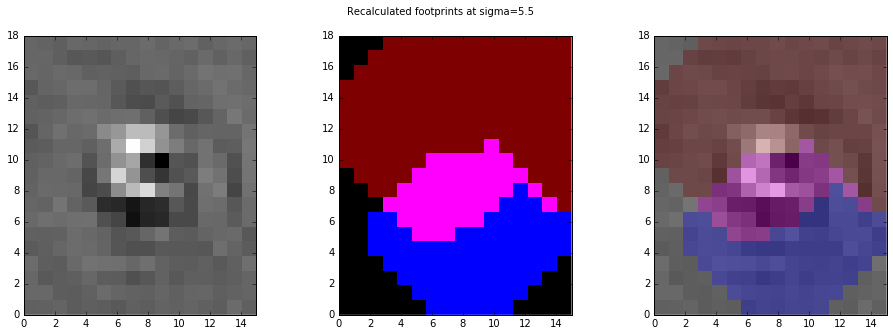

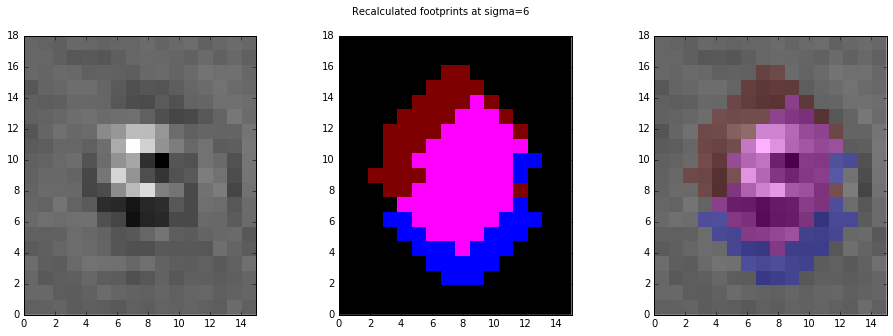

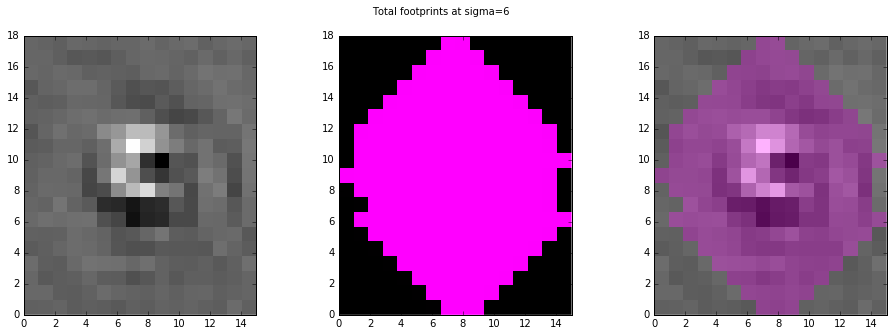

In [74]:
reload(DSTools)

img_arr, mask_arr, var_arr = stamp.getMaskedImage().getArrays()

show_stamps(stamp, title="Recalculated footprints at sigma=5.5")


stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
img_arr, mask_arr, var_arr = stamp_clone.getMaskedImage().getArrays()

show_stamps(stamp_clone, title="Recalculated footprints at sigma=6")



stamp_clone = stamp.clone()
mi = stamp_clone.getMaskedImage()
mask = mi.getMask()
mask &= (~mask.getPlaneBitMask("DETECTED"))
mask &= (~mask.getPlaneBitMask("DETECTED_NEGATIVE"))
fp = source.getFootprint()
mplane = mask.addMaskPlane("CORR_DETECTED")
w = stamp.getWidth()
h = stamp.getHeight()
for i in range(w):
    for j in range (h):
        if fp.contains(afwGeom.Point2I(i+stamp.getX0(),j+stamp.getY0())):
            #print True
            mask[i,j] = mplane
    
show_stamps(stamp_clone, title="Total footprints at sigma=6")



## Part 3: Characterization Tests

This intends to test some hypothesis to improve the number of detected DIASources. We start by calculating the DIASources on one CCD, again.

In [ ]:


diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':filter , 'ccd':14})
            
            
            
for i in range(4,7):
        try:
            results = DSTools.detect_diasources(diffExp, doSmooth=False, threshold=i)
            diaSources = merge_sources(results)
            dipoleMeasurement.run(diaSources, diffExp)
            diaSources = remove_nan_sources(diaSources)

            if source_catalogs[i-4] == None:
                source_catalogs[i-4] = diaSources
            else:
                source_catalogs[i-4].extend(diaSources)
        except Exception, e:
            print e


Here we calculate the $\sigma$ of the background

In [ ]:
bkg, exp = SubtractBackground(diffExp)

arr = bkg.getImageF().getArray()
sigma = np.std(arr)

Then, we threshold the pixels whose absolute values are higher than $6\sigma$

In [ ]:
t =sigma*6

stamp_th = diffExp.clone()

stamp_im = stamp_th.getMaskedImage().getImage()
im = stamp_im.getArray()
for x in range(stamp_im.getWidth()):
    for y in range(stamp_im.getHeight()):
        if np.abs(stamp_im.get(x,y)) > t:
            stamp_im.set(x,y,1)
        else:
            stamp_im.set(x,y,0)
            
            
ds9.mtv(stamp_im, frame=5)

In [ ]:
ds9.mtv(diffExp, frame=6)

In [ ]:
import skimage
from skimage import measure
from skimage import data
from skimage import filters
from scipy import ndimage
from skimage.measure import regionprops

We use scikit-image and ndimage to perform an erosion to delete all the little fluctuations and then label the different connected components. We then measure the centroids and save the results

In [ ]:

blobs = stamp_im.getArray()
res = ndimage.binary_opening(blobs, np.ones((3,3)).astype(np.int))

In [ ]:

all_labels = measure.label(res)
blobs_labels, lab_num = measure.label(res, background=0, return_num = True)
regions = regionprops(blobs_labels)

In [ ]:
ds9.mtv(diffExp, frame=1)
for props in regions:
    y0,x0 = props.centroid
    ds9.dot('+', x0, y0, size=50, ctype=ds9.RED, frame=1)
    

In [ ]:
for diaSrc in diaSources:
    ds9.dot('o', diaSrc.getX(), diaSrc.getY(), size=20, ctype=ds9.BLUE, frame=1)

Qualitative comparisons show some differences. The number of sources detected after this is lower, but there are some artifacts worth considering.

In [ ]:
print len(diaSources)
print lab_num

Some visualizations of the results

In [ ]:
plt.figure(figsize=(30,15))

plt.imshow(blobs_labels)

In [ ]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(30,15))


ax.imshow(blobs_labels) 
for props in regions:
    y0,x0 = props.centroid
    ax.plot(x0, y0, '.r', markersize=5)
    

plt.show()

In [ ]:
ds9.mtv(stamp_im, frame=5)

## Dipole Tagging Test

In [196]:
catalog_s6 = source_catalogs[2]

classification = []

for source in catalog_s6:
    
    stamp, center = get_source_stamp(source, visit, ccds, offset=10)
    if stamp is not None:
        stamp_clone = stamp.clone()
        results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)


        if len(results.fpSets.positive.getFootprints()) == 0 and len(results.fpSets.negative.getFootprints()) > 0:
            classification.append(('Negative', source))
        elif len(results.fpSets.positive.getFootprints()) > 0 and len(results.fpSets.negative.getFootprints()) == 0:
            classification.append(('Positive', source))
        else:
            label = 'Dipole'
            stamp_clone = stamp.clone()
            results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
            photo, geom = get_dipole_lobes_metrics(stamp_clone)

            p_dipole, g_dipole = photo_dipole(photo), geom_dipole(geom)

            if p_dipole and g_dipole:
                label = "Dipole type I"
            elif p_dipole and not g_dipole:
                label = "Dipole type II"
            elif not p_dipole and g_dipole:
                label = "Fringe"
            else:
                label = "Artifact"
            classification.append((label, source))

        
    
    #img_arr, mask_arr, var_arr = stamp_clone.getMaskedImage().getArrays()
    
    

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in greater
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: RuntimeWarning: invalid value encountered in less


In [204]:
objects = {}

for label, src in classification:
    if label in objects:
        objects[label] += 1
    else:
        objects[label] = 1

In [213]:
o_objects

OrderedDict([('Positive', 1291),
             ('Fringe', 656),
             ('Dipole type I', 730),
             ('Artifact', 227),
             ('Dipole type II', 797),
             ('key', <operator.itemgetter at 0x7fdd70f2f550>)])

OrderedDict([('Positive', 1291), ('Dipole type II', 797), ('Dipole type I', 730), ('Fringe', 656), ('Artifact', 227)])


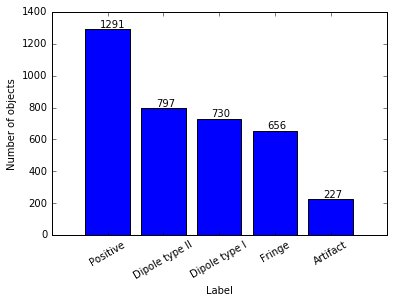

In [227]:
import collections
from operator import itemgetter

o_objects = collections.OrderedDict(sorted(objects.items(), key=itemgetter(1), reverse=True))
print o_objects
X = np.arange(len(o_objects))

p = plt.bar(X, o_objects.values(), align='center')
plt.xticks(X, o_objects.keys(), rotation=30)

plt.xlabel("Label")
plt.ylabel("Number of objects")
for i, rect in enumerate(p):
    plt.text(rect.get_x()+ rect.get_width()/3, rect.get_height()+10, int(rect.get_height()))

plt.show()

In [240]:
label, source = random.choice(classification)
while label is not "Positive":
    print label
    label, source = random.choice(classification)
print label    

Dipole type I
Artifact
Positive


Positive


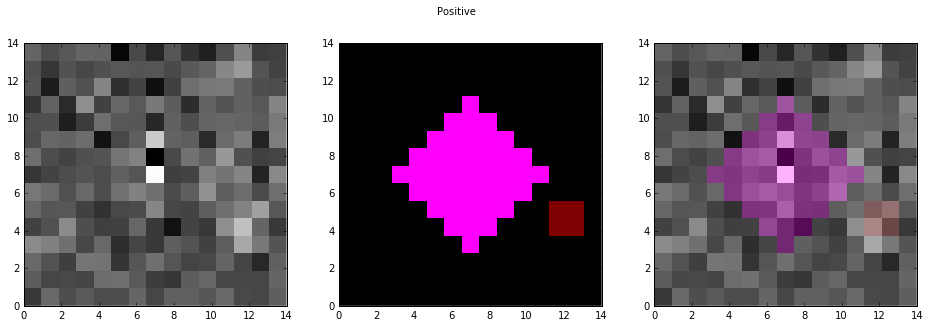

In [245]:

count = 0
while count < 1:
    label, source = random.choice(classification)
    while label is not "Positive":
        label, source = random.choice(classification)
    print label
        
    stamp, center = get_source_stamp(source, visit, ccds, offset=10)
    stamp_clone = stamp.clone()
    results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
    show_stamps(stamp_clone, title=label)
    count +=1

In [280]:
img_arr, mask_arr, var_arr = stamp_clone.getMaskedImage().getArrays()

In [248]:
print type(img_arr)

<type 'numpy.ndarray'>


/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/skimage/filters/_gaussian.py:13: skimage_deprecation: Call to deprecated function ``gaussian_filter``. Use ``skimage.filters.gaussian`` instead.
  multichannel=None):


[[ -47.90031993  -38.98285125]
 [ -38.98285125  101.00133288]]
[ -57.48870012  110.58971307]


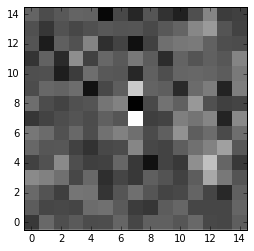

In [301]:
import skimage
from skimage import measure
from skimage import data
from skimage import filters
from scipy import ndimage
from skimage.measure import regionprops
from skimage.measure import moments
from skimage.measure import moments_central
n=10
l=256
im = np.zeros((256, 256))
points = l * np.random.random((2, n ** 2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = filters.gaussian_filter(im, sigma=l / (4. * n))
blobs = im > im.mean()


img_arr = img_arr.astype(float)
m = moments(img_arr, order=1)

#print m[0,1]/m[0,0], m[1,0]/m[0,0]

plt.imshow(img_arr, origin='lower', vmin=img_arr.min(), vmax=img_arr.max(), cmap='gray',  interpolation='none')
#print stamp_clone.getX0()
#print stamp_clone.getY0()
#print source.getCentroid()

m_c = moments_central(img_arr, 5, 5, order=2)

cov = [[m_c[2,0]/m_c[0,0], m_c[1,1]/m_c[0,0]], [m_c[1,1]/m_c[0,0], m_c[0,2]/m_c[0,0]]]
print np.matrix(cov)
v, w = np.linalg.eig(cov)
print v

In [285]:
regionprops(img_arr)

TypeError: Label image must be of integral type.

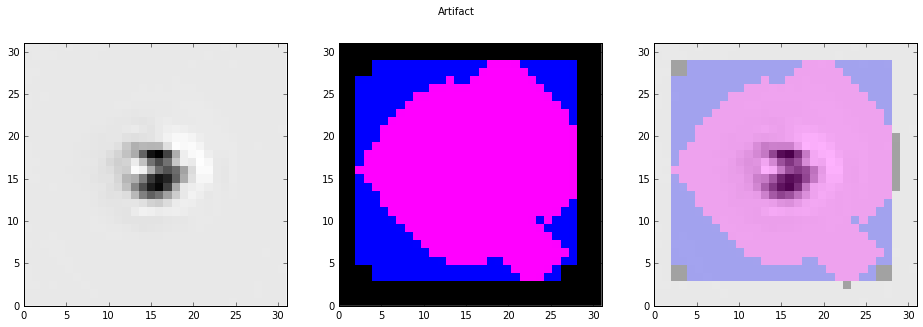

In [186]:
label, source = random.choice(classification)
stamp, center = get_source_stamp(source, visit, ccds, offset=10)
stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
show_stamps(stamp_clone, title=label)

1.83352084006


([0.91741651, 0.96286631, 0.93988526],
 [0.3301818181818182, 0.45454545454545453, 0.5243636363636364])

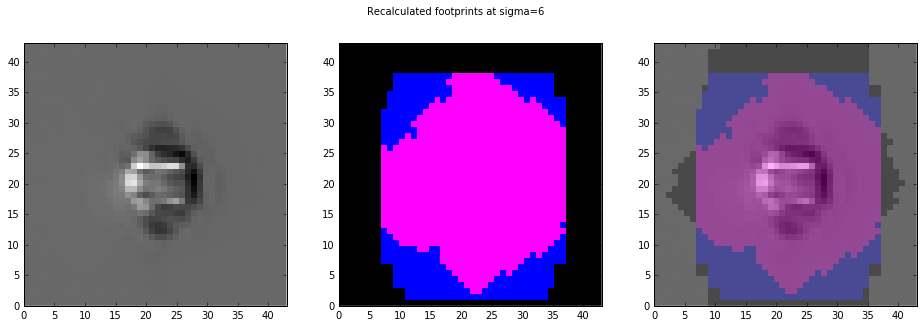

In [88]:
catalog_s6 = source_catalogs[2]
source = random.choice(catalog_s6)
stamp, center = get_source_stamp(source, visit, ccds, offset=10)
stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
img_arr, mask_arr, var_arr = stamp_clone.getMaskedImage().getArrays()

show_stamps(stamp_clone, title="Recalculated footprints at sigma=6")

get_dipole_lobes_metrics(stamp_clone)


In [122]:
print photo, geom

stamp_clone = stamp.clone()
results = DSTools.detect_diasources(stamp_clone, doSmooth=False,threshold=6)
photo, geom = get_dipole_lobes_metrics(stamp_clone)

p_dipole, g_dipole = photo_dipole(photo), geom_dipole(geom)

if p_dipole and geom_dipole(geom):
    print "Dipole type I"
elif p_dipole and not g_dipole:
    print "Dipole type II"
elif not p_dipole and g_dipole:
    print "Fringe"
else:
    print "Artifact"


[0.93107057, 0.37557745, 0.62387079] [0.5089686098654709, 0.7006726457399103, 0.8082959641255605]
Dipole type II


In [188]:
print(len(source_catalogs[2]))

3702
